In [1]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torchvision.transforms as T
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
from PIL import ImageOps
from tqdm import tqdm
from utils import prepare_image
from utils import prepare_mask_and_masked_image
from utils import recover_image

to_pil = T.ToPILImage()

### First lets instantiate an inpainting stable diffusion model

In [2]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details

pipe_inpaint: StableDiffusionInpaintPipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    # revision="fp16",
    torch_dtype=torch.float16,
)  # type: ignore
device = "cuda" if torch.cuda.is_available() else "cpu"

# pipe_inpaint.unet = pipe_inpaint.unet.to(memory_format=torch.channels_last)
# pipe_inpaint.vae = pipe_inpaint.vae.to(memory_format=torch.channels_last)
pipe_inpaint.fuse_qkv_projections()

pipe_inpaint.vae = torch.compile(
    pipe_inpaint.vae,
    fullgraph=True,
    backend="cudagraphs",
)
for name, child in pipe_inpaint.unet.down_blocks.named_children():
  child = torch.compile(
      child,
      fullgraph=True,
      # backend="cudagraphs",
      mode="reduce-overhead",
  )
for name, child in pipe_inpaint.unet.up_blocks.named_children():
  child = torch.compile(
      child,
      fullgraph=True,
      # backend="cudagraphs",
      mode="reduce-overhead",
  )

pipe_inpaint.unet.mid_block = torch.compile(
    pipe_inpaint.unet.mid_block,
    fullgraph=True,
    # backend="cudagraphs",
    mode="reduce-overhead",
)

pipe_inpaint = pipe_inpaint.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/jakub/miniconda3/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/jakub/miniconda3/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


### The image to immunize
Now let's load image + some mask so that we can inpaint the rest!

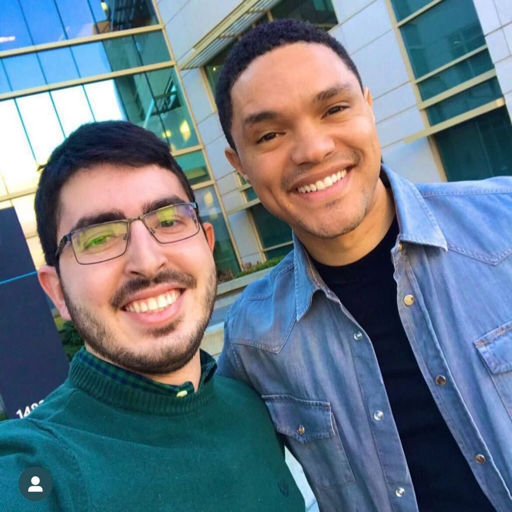

In [3]:
assets_path = "../../photoguard/assets"
image_size = 512
init_image = Image.open(f"{assets_path}/trevor_5.jpg").convert('RGB').resize(
    (image_size, image_size)
)
mask_image = Image.open(f"{assets_path}/trevor_5.tif").convert('RGB')
mask_image = ImageOps.invert(mask_image).resize((image_size, image_size))
init_image

### Target image
Here, different from the img2img notebook, we will drive the above image towards the embedding of some random target image from the internet!

You can still effectively attack towards an embedding of zeros too! 

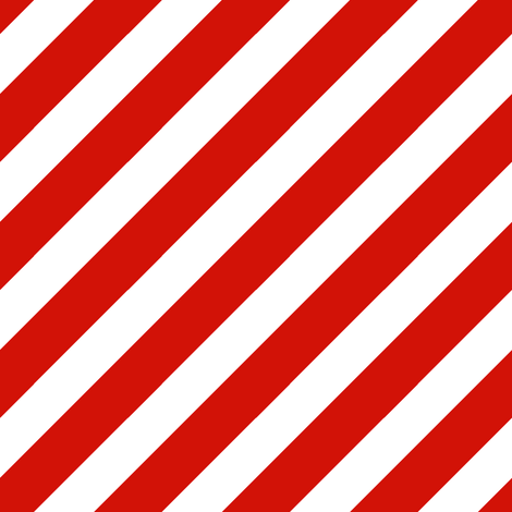

In [4]:
# target_url = "https://srv-2.eden-gallery.com/wp-content/uploads/sites/15/2018/04/eden-fine-art-yoel-benharrouche-l_etape-intermediaire_2.jpg"
# target_url = "https://previews.123rf.com/images/marsono/marsono1708/marsono170800715/85827714-logotipo-de-advertencia-tri%C3%A1ngulo-rojo.jpg"
target_url = "https://i.pinimg.com/originals/18/37/aa/1837aa6f2c357badf0f588916f3980bd.png"
response = requests.get(target_url)
target_image = Image.open(BytesIO(response.content)).convert("RGB")
target_image = target_image.resize((image_size, image_size))
target_image

### Complex attack implementation
Below is the implementation of an end2end attack on the stable diffusion pipeline using PGD. This requires a GPU Memory >= 40Gbs (we ran on 1 A100)

In [5]:
# A differentiable version of the forward function of the inpainting stable diffusion model! See https://github.com/huggingface/diffusers
def attack_forward(
    pipe: StableDiffusionInpaintPipeline,
    prompt: str | list[str],
    masked_image: torch.FloatTensor,
    mask: torch.FloatTensor,
    height: int = 512,
    width: int = 512,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    eta: float = 0.0,
    device: str = "cuda",
) -> torch.Tensor:

  text_inputs = pipe.tokenizer(
      prompt,
      padding="max_length",
      max_length=pipe.tokenizer.model_max_length,
      return_tensors="pt",
  )
  text_input_ids = text_inputs.input_ids
  text_encoder_prev_device = pipe.text_encoder.device
  pipe.text_encoder = pipe.text_encoder.to(device)
  text_embeddings = pipe.text_encoder(text_input_ids.to(device))[0]

  uncond_tokens = [""]
  max_length = text_input_ids.shape[-1]
  uncond_input = pipe.tokenizer(
      uncond_tokens,
      padding="max_length",
      max_length=max_length,
      truncation=True,
      return_tensors="pt",
  )
  uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]
  pipe.text_encoder = pipe.text_encoder.to(text_encoder_prev_device)
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  text_embeddings = text_embeddings.detach()

  num_channels_latents = pipe.vae.config.latent_channels

  latents_shape = (1, num_channels_latents, height // 8, width // 8)
  latents = torch.randn(
      latents_shape, device=device, dtype=text_embeddings.dtype
  )

  mask = torch.nn.functional.interpolate(mask, size=(height // 8, width // 8))
  mask = torch.cat([mask] * 2)  # type: ignore

  # Ensure VAE is on the device
  vae_prev_device = pipe.vae.device
  pipe.vae = pipe.vae.to(device)
  masked_image_latents = pipe.vae.encode(masked_image).latent_dist.sample()
  pipe.vae = pipe.vae.to(vae_prev_device)

  masked_image_latents = 0.18215 * masked_image_latents
  masked_image_latents = torch.cat([masked_image_latents] * 2)

  latents = latents * pipe.scheduler.init_noise_sigma

  pipe.scheduler.set_timesteps(num_inference_steps)
  timesteps_tensor = pipe.scheduler.timesteps.to(device)

  unet_prev_device = pipe.unet.device
  pipe.unet = pipe.unet.to(device)
  for _, t in enumerate(timesteps_tensor):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = torch.cat(
        [latent_model_input, mask, masked_image_latents], dim=1
    )
    noise_pred = pipe.unet(
        latent_model_input,
        t,
        encoder_hidden_states=text_embeddings,
        return_dict=False
    )[0]
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

  pipe.unet = pipe.unet.to(unet_prev_device)

  latents = 1 / 0.18215 * latents

  pipe.vae = pipe.vae.to(device)
  image = pipe.vae.decode(latents).sample
  pipe.vae = pipe.vae.to(vae_prev_device)
  return image


def compute_grad(
    cur_mask: torch.Tensor,
    cur_masked_image: torch.Tensor,
    prompt: str | list[str],
    target_image: torch.Tensor,
    **kwargs,
):
  torch.compiler.cudagraph_mark_step_begin()
  torch.set_grad_enabled(True)
  cur_mask = cur_mask.clone()
  cur_masked_image = cur_masked_image.clone()
  cur_mask.requires_grad = False
  cur_masked_image.requires_grad_()
  image_nat = attack_forward(
      pipe_inpaint,
      mask=cur_mask,
      masked_image=cur_masked_image,
      prompt=prompt,
      **kwargs
  )

  loss = (image_nat - target_image).norm(p=2)
  grad = torch.autograd.grad(loss, [cur_masked_image])[0] * (1 - cur_mask)

  return grad, loss.item(), image_nat.data.cpu()


def super_linf(
    cur_mask,
    X,
    prompt,
    step_size,
    iters,
    eps,
    clamp_min,
    clamp_max,
    grad_reps=5,
    target_image=0,
    **kwargs
):
  X_adv = X.clone()
  iterator = tqdm(range(iters))
  for i in iterator:

    all_grads = []
    losses = []
    for i in range(grad_reps):
      c_grad, loss, last_image = compute_grad(
          cur_mask, X_adv, prompt, target_image=target_image, **kwargs
      )
      all_grads.append(c_grad)
      losses.append(loss)

    grad = torch.stack(all_grads).mean(0)

    iterator.set_description_str(f'AVG Loss: {np.mean(losses):.3f}')

    # actual_step_size = step_size - (step_size - step_size / 100) / iters * i
    actual_step_size = step_size
    X_adv = X_adv.detach()
    X_adv = X_adv - grad.detach().sign() * actual_step_size

    X_adv = torch.minimum(torch.maximum(X_adv, X - eps), X + eps)
    X_adv.data = torch.clamp(X_adv, min=clamp_min, max=clamp_max)

  torch.cuda.empty_cache()

  return X_adv, last_image



### Executing the attack
Now we apply the attack to our image

In [6]:
prompt = ""
SEED = 786349
torch.manual_seed(SEED)

strength = 0.7
guidance_scale = 7.5
num_inference_steps = 4

cur_mask, cur_masked_image = prepare_mask_and_masked_image(
    init_image, mask_image
)

cur_mask = cur_mask.half().cuda()
cur_masked_image = cur_masked_image.half().cuda()
target_image_tensor = prepare_image(target_image)
target_image_tensor = 0 * target_image_tensor.cuda(
)  # we can either attack towards a target image or simply the zero tensor

result, last_image = super_linf(
    cur_mask,
    cur_masked_image,
    prompt=prompt,
    target_image=target_image_tensor,
    eps=0.1,
    step_size=0.006,
    iters=200,
    clamp_min=-1,
    clamp_max=1,
    height=image_size,
    width=image_size,
    eta=1,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
)

AVG Loss: 198.508:  20%|█▉        | 39/200 [01:28<06:07,  2.28s/it]


KeyboardInterrupt: 

In [ ]:
## Alternatively you can run an l_inf pgd attack
# result, last_image= super_linf(cur_mask, cur_masked_image,
#                   prompt=prompt,
#                   target_image=target_image_tensor,
#                   eps=0.1,
#                   step_size=0.006,
#                   iters=200,
#                   clamp_min = -1,
#                   clamp_max = 1,
#                   height = 512,
#                   width = 512,
#                   eta=1,
#                   num_inference_steps=num_inference_steps,
#                   guidance_scale=guidance_scale,
#                  )

In [ ]:
adv_X = (result / 2 + 0.5).clamp(0, 1)

adv_image = to_pil(adv_X[0]).convert("RGB")
adv_image = recover_image(adv_image, init_image, mask_image, background=True)
adv_image
adv_image.save('photoguard_larger_adv.png')

### Running Stable Diffusion Inpainting
Now that we generated an "immunized"/adversarial image, lets try to run inpainting using stable diffusion on both the original and the adversarial images

In [ ]:
# prompt = "man riding a motorcycle at night"
# prompt = "two men in a wedding"
# prompt = "two men in a restaurant hugging"
# prompt = "two men in a classroom"
# prompt = "two men in a library"
prompt = "two men in the plane hugging"

# A good seed
SEED = 9209

# Uncomment the below to generated other images
# SEED = np.random.randint(low=0, high=100000)
print(SEED)

torch.manual_seed(SEED)
strength = 0.7
guidance_scale = 7.5
num_inference_steps = 100

image_nat = pipe_inpaint(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
    eta=1,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    strength=strength
).images[0]
print(image_nat)
image_nat = recover_image(
    image_nat.resize((image_size, image_size)), init_image, mask_image
)

torch.manual_seed(SEED)
image_adv = pipe_inpaint(
    prompt=prompt,
    image=adv_image,
    mask_image=mask_image,
    eta=1,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    strength=strength
).images[0]
image_adv = recover_image(
    image_adv.resize((image_size, image_size)), init_image, mask_image
)

9209


  0%|          | 0/70 [00:00<?, ?it/s]

E0313 23:22:41.462000 43285 site-packages/torch/_inductor/select_algorithm.py:1300] [0/1] Exception out of resource: shared memory, Required: 110592, Hardware limit: 101376. Reducing block sizes or `num_stages` may help. for benchmark choice TritonTemplateCaller(/tmp/torchinductor_jakub/ds/cdsjkusqzhrxpthcoxkyl2f4ysqrr6ragkgw7evqz2v5zz5zhktm.py, ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=128, BLOCK_M=16, BLOCK_N=128, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=4, num_warps=4)
W0313 23:22:42.877000 43285 site-packages/torch/_inductor/select_algorithm.py:1517] [0/1] out of resource: shared memory, Required: 110592, Hardware limit: 101376. Reducing block sizes or `num_stages` may help.
AUTOTUNE mm(2x320, 320x1280)
  triton_mm_18 0.0061 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=False, BLOCK_K=128, BLOCK_M=16, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=2
  triton_mm_21 0.0061 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F3848B8C230>


  0%|          | 0/70 [00:00<?, ?it/s]

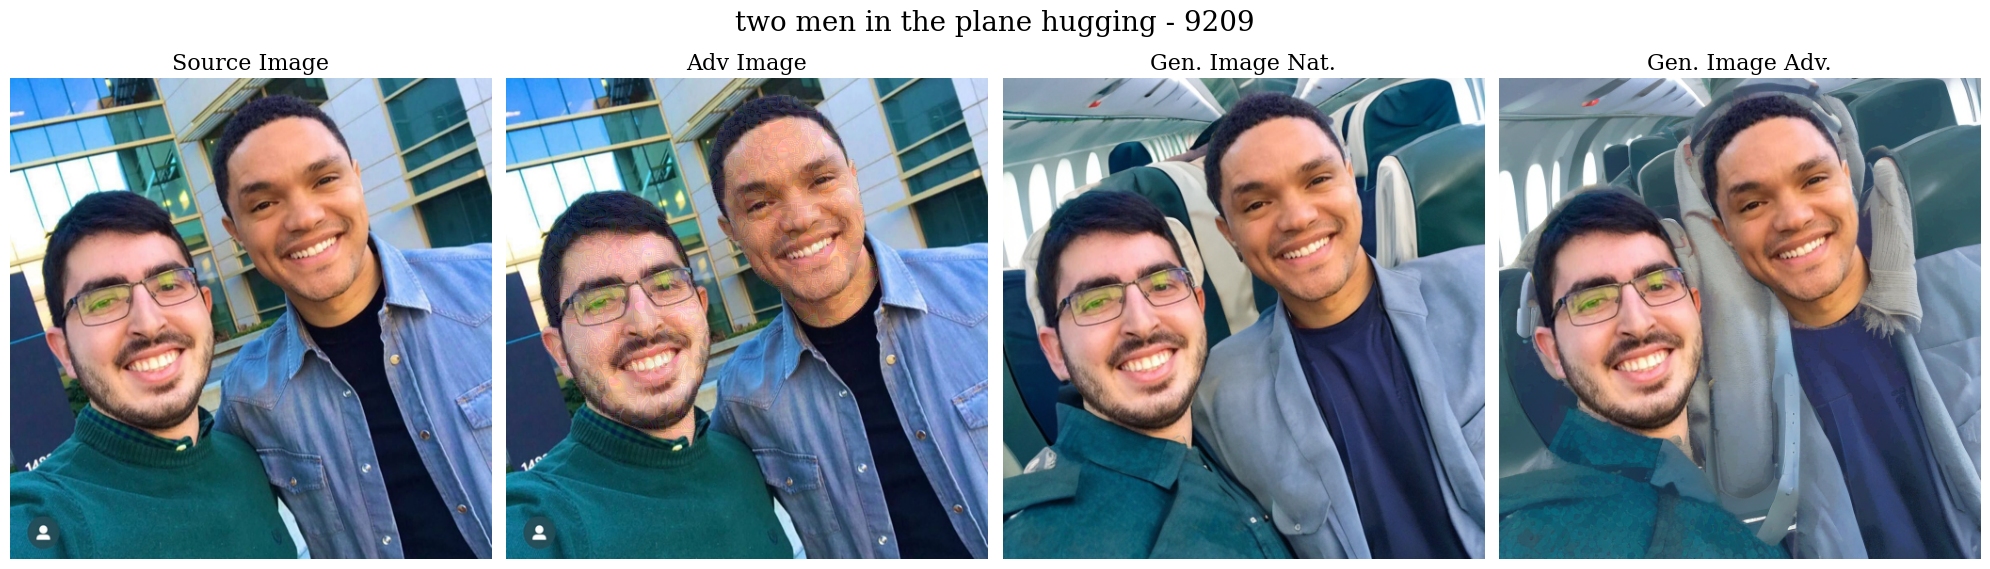

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

ax[0].imshow(init_image)
ax[1].imshow(adv_image)
ax[2].imshow(image_nat)
ax[3].imshow(image_adv)

ax[0].set_title('Source Image', fontsize=16)
ax[1].set_title('Adv Image', fontsize=16)
ax[2].set_title('Gen. Image Nat.', fontsize=16)
ax[3].set_title('Gen. Image Adv.', fontsize=16)

for _ in range(4):
  ax[_].grid(False)
  ax[_].axis('off')

fig.suptitle(f"{prompt} - {SEED}", fontsize=20)
fig.tight_layout()
plt.show()
plt.savefig('photoguard_larger.png')

#### Notice how now the generated image from the adversarial example is completely unrealistic! Much stronger result than the simple attack of `demo_simple_attack_inpainting.ipynb`